# old apporach

In [1]:
!pip -q install mne umap-learn plotly==5.* seaborn


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 42.9 MB/s eta 0:00:00


In [18]:
import os
from glob import glob

csv_paths = sorted(glob("*.csv"))
files = [(p, f"env_{i+1}") for i, p in enumerate(csv_paths)]
K = len(files)

for p, lab in files:
    print(f"{p} -> {lab}")


lsl_stream_20250809_154545.csv -> env_1
lsl_stream_20250809_155123.csv -> env_2
lsl_stream_20250809_155739.csv -> env_3
lsl_stream_20250809_160350.csv -> env_4


In [19]:
FS = 250.0  # Hz

In [20]:
import re, unicodedata, numpy as np, pandas as pd, mne
from mne.time_frequency import psd_array_welch

def _clean_cols(df: pd.DataFrame):
    def clean_col(c: str) -> str:
        c = unicodedata.normalize("NFKC", str(c)).replace("\u00a0"," ").replace("\u200b","")
        c = c.strip().lower()
        c = re.sub(r"\s+", "_", c)
        c = c.replace("chan_", "channel_").replace("ch_", "channel_")
        c = re.sub(r"[^a-z0-9_]", "", c)
        c = re.sub(r"channel(\d)", r"channel_\1", c)
        return c
    df.columns = [clean_col(c) for c in df.columns]
    return df

def load_csv(path: str):
    df = pd.read_csv(path, comment="#", skipinitialspace=True, engine="python")
    df = _clean_cols(df)
    # find channels
    chan_cols = [c for c in df.columns if re.fullmatch(r"channel_\d+", c)]
    if not chan_cols:
        # fallback: numeric non-time columns
        num_cols = df.select_dtypes(include="number").columns.tolist()
        time_like = [c for c in df.columns if "timestamp" in c or "time_iso" in c]
        chan_cols = [c for c in num_cols if c not in time_like]
    # build time base
    if "lsl_timestamp" in df.columns:
        t = df["lsl_timestamp"].astype(float).to_numpy()
    elif "unix_timestamp" in df.columns:
        t = df["unix_timestamp"].astype(float).to_numpy()
        if t.max() > 1e11: t = t / 1000.0
    else:
        t = np.arange(len(df)) / FS
    t = t - t[0]
    X = df[chan_cols].apply(pd.to_numeric, errors="coerce").to_numpy().T  # (n_ch, n_samples)
    good = np.isfinite(X).all(axis=0)
    return X[:, good], t[good], chan_cols

def preprocess(X):
    X = mne.filter.filter_data(X, FS, 0.5, 45.0, verbose=False)
    # X = mne.filter.notch_filter(X, FS, freqs=[60], verbose=False)  # uncomment if needed
    X = X - X.mean(axis=0, keepdims=True)  # CAR
    return X

def epoch_array(X, t, win=10.0, ovl=1):
    step = int((1-ovl)*win*FS); wlen = int(win*FS)
    starts = np.arange(0, X.shape[1]-wlen+1, step)
    Xep = np.stack([X[:, s:s+wlen] for s in starts])      # (n_epochs, n_ch, n_times)
    t_mid = np.array([t[s:s+wlen].mean() for s in starts])
    return Xep, t_mid

def bandpower_epoch(epoch, fmin, fmax):
    # epoch: (n_ch, n_times)
    n = epoch.shape[-1]
    nps = 2 ** int(np.floor(np.log2(n)))    # largest power-of-two <= n
    nps = max(128, min(nps, n))
    noverlap = nps // 2
    psd, freqs = psd_array_welch(epoch, FS, n_per_seg=nps, n_overlap=noverlap,
                                 n_fft=nps, fmin=fmin, fmax=fmax, verbose=False)
    return psd.mean(axis=1)  # mean per channel


In [21]:
from scipy import linalg

BANDS = {"theta": (4,7), "alpha": (8,12), "beta": (13,30), "gamma": (30,45)}

def features_from_epochs(Xep):
    rows = []
    for e in Xep:  # (n_ch, n_times)
        # band powers per channel
        bp = {name: bandpower_epoch(e, lo, hi) for name,(lo,hi) in BANDS.items()}  # each (n_ch,)
        # aggregate across channels
        agg = {}
        for name, v in bp.items():
            agg[f"{name}_mean"] = float(np.mean(v))
            agg[f"{name}_std"]  = float(np.std(v))
        # ratios
        alpha = agg["alpha_mean"] + 1e-9
        agg["theta_over_alpha"] = agg["theta_mean"] / alpha
        agg["beta_gamma_over_alpha"] = (agg["beta_mean"] + agg["gamma_mean"]) / alpha
        # simple spatial stats from channel covariance
        C = np.cov(e)  # (n_ch, n_ch)
        vals = np.sort(linalg.eigvalsh(C))
        vals = np.clip(vals, 1e-12, None)
        s = vals.sum()
        agg["cov_logdet"] = float(np.log(vals).sum())
        agg["cov_cond"] = float(vals[-1] / vals[0])
        agg["cov_eig1_frac"] = float(vals[-1] / s)
        agg["mean_abs_corr"] = float(np.mean(np.abs(np.corrcoef(e))))
        rows.append(agg)
    return pd.DataFrame(rows)


In [22]:
import pandas as pd

all_feat = []
for path, label in files:
    X, t, chan_cols = load_csv(path)
    X = preprocess(X)
    Xep, t_mid = epoch_array(X, t, win=10.0, ovl=2)
    feat = features_from_epochs(Xep)
    feat["t_mid_s"] = t_mid
    feat["session"] = label
    feat["file"] = path
    all_feat.append(feat)

data = pd.concat(all_feat, ignore_index=True)
print(data.shape)
data.head()


ValueError: need at least one array to stack

In [9]:
from sklearn.preprocessing import StandardScaler

# z-score per file (session-wise), then global z-score
data_std = data.copy()
num_cols = data.select_dtypes(include=float).columns.tolist()
num_cols = [c for c in num_cols if c not in ("t_mid_s",)]

data_std[num_cols] = data_std.groupby("file")[num_cols].transform(
    lambda x: (x - x.mean()) / (x.std(ddof=0) + 1e-9)
)
Z = StandardScaler().fit_transform(data_std[num_cols])
y_true = data["session"].to_numpy()


In [10]:
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score

kmeans = KMeans(n_clusters=4, n_init=30, random_state=0).fit(Z)
gmm = GaussianMixture(n_components=4, covariance_type="full", random_state=0).fit(Z)
labels_km = kmeans.labels_
labels_gm = gmm.predict(Z)

print("KMeans  ARI:", adjusted_rand_score(y_true, labels_km),
      " NMI:", normalized_mutual_info_score(y_true, labels_km))
print("GMM     ARI:", adjusted_rand_score(y_true, labels_gm),
      " NMI:", normalized_mutual_info_score(y_true, labels_gm))


KMeans  ARI: 0.00012689341856950227  NMI: 0.0030839924623347658
GMM     ARI: 0.30998901781472626  NMI: 0.49555428910702976


/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


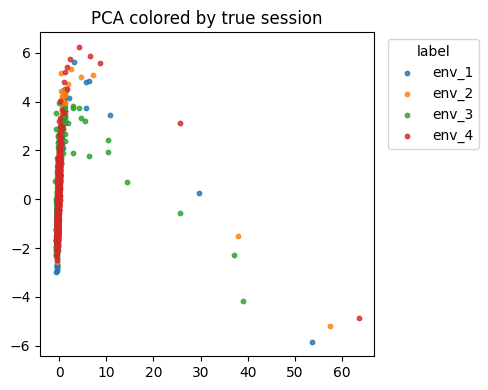

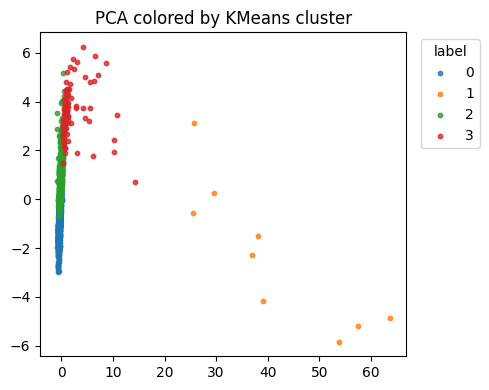

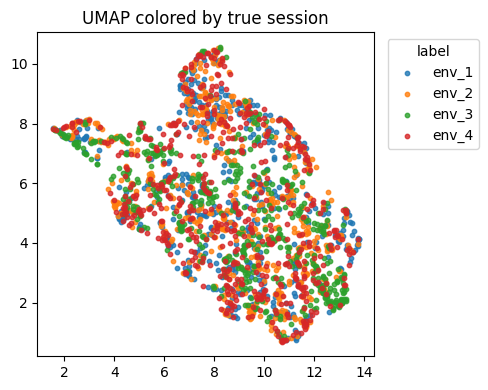

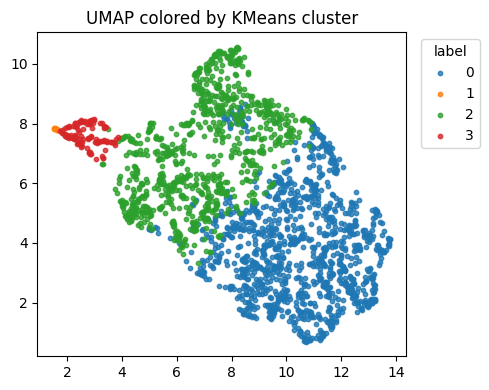

In [12]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import umap

pca2 = PCA(n_components=2, random_state=0).fit_transform(Z)
um2  = umap.UMAP(random_state=42).fit_transform(Z)

def scatter(X2, color, title):
    plt.figure(figsize=(5,4))
    for s in np.unique(color):
        m = color==s
        plt.scatter(X2[m,0], X2[m,1], s=10, label=str(s), alpha=0.8)
    plt.legend(title="label", bbox_to_anchor=(1.02,1), loc="upper left")
    plt.title(title); plt.tight_layout(); plt.show()

scatter(pca2, y_true, "PCA colored by true session")
scatter(pca2, labels_km, "PCA colored by KMeans cluster")

scatter(um2, y_true, "UMAP colored by true session")
scatter(um2, labels_km, "UMAP colored by KMeans cluster")


# new stuff

In [1]:
!pip -q install mne umap-learn seaborn xgboost


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 67.1 MB/s eta 0:00:00


In [2]:
import os, re, unicodedata, numpy as np, pandas as pd, matplotlib.pyplot as plt, seaborn as sns
from glob import glob
from typing import List, Tuple
import warnings
warnings.filterwarnings("ignore")

import mne
from mne.time_frequency import psd_array_welch
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.decomposition import PCA
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score
import umap

plt.rcParams["figure.dpi"] = 120
sns.set(style="whitegrid", rc={"axes.spines.right": False, "axes.spines.top": False})


In [3]:
# Try interactive upload first; if you cancel, it will auto-discover *.csv in cwd
from google.colab import files
try:
    uploaded = files.upload()  # you can select multiple CSVs
    csv_paths = sorted([p for p in uploaded.keys() if p.lower().endswith(".csv")])
    if not csv_paths:
        raise RuntimeError("No CSVs uploaded.")
except Exception:
    csv_paths = sorted([p for p in glob("*.csv") if p.lower().endswith(".csv")])

assert csv_paths, "No CSV files found. Upload or place CSVs in the working directory."

def label_from_filename(p):
    stem = os.path.splitext(os.path.basename(p))[0]
    return re.sub(r"[^A-Za-z0-9_]+", "_", stem).strip("_")

files_list = [(p, label_from_filename(p)) for p in csv_paths]
print("Found CSVs:")
for p, lab in files_list:
    print(f"  {p}  ->  class: {lab}")
K_true = len(files_list)


Saving lsl_stream_20250809_160350.csv to lsl_stream_20250809_160350.csv
Saving lsl_stream_20250809_155739.csv to lsl_stream_20250809_155739.csv
Saving lsl_stream_20250809_155123.csv to lsl_stream_20250809_155123.csv
Saving lsl_stream_20250809_154545.csv to lsl_stream_20250809_154545.csv
Found CSVs:
  lsl_stream_20250809_154545.csv  ->  class: lsl_stream_20250809_154545
  lsl_stream_20250809_155123.csv  ->  class: lsl_stream_20250809_155123
  lsl_stream_20250809_155739.csv  ->  class: lsl_stream_20250809_155739
  lsl_stream_20250809_160350.csv  ->  class: lsl_stream_20250809_160350


In [4]:
DEFAULT_FS = 250.0  # used if we cannot infer a sensible sampling rate

def _clean_cols(df: pd.DataFrame):
    def clean_col(c: str) -> str:
        c = unicodedata.normalize("NFKC", str(c)).replace("\u00a0"," ").replace("\u200b","")
        c = c.strip().lower()
        c = re.sub(r"\s+", "_", c)
        c = c.replace("chan_", "channel_").replace("ch_", "channel_")
        c = re.sub(r"[^a-z0-9_]", "", c)
        c = re.sub(r"channel(\d)", r"channel_\1", c)
        return c
    df.columns = [clean_col(c) for c in df.columns]
    return df

def _estimate_fs_from_t(t):
    if t is None or len(t) < 3:
        return DEFAULT_FS
    dt = np.diff(t)
    dt = dt[dt > 0]
    if len(dt) == 0:
        return DEFAULT_FS
    fs = 1.0 / np.median(dt)
    return float(fs)

def _safe_fs(fs):
    # guard against bogus inference (e.g., <20 Hz or >2 kHz for EEG)
    return fs if 20.0 <= fs <= 2000.0 else DEFAULT_FS

def load_csv(path: str):
    df = pd.read_csv(path, comment="#", skipinitialspace=True, engine="python")
    df = _clean_cols(df)

    # time base (prefer lsl_timestamp, then unix_timestamp)
    t_raw = None
    if "lsl_timestamp" in df.columns:
        t_raw = df["lsl_timestamp"].astype(float).to_numpy()
    elif "unix_timestamp" in df.columns:
        t_raw = df["unix_timestamp"].astype(float).to_numpy()
        if t_raw.max() > 1e11:  # ms since epoch
            t_raw = t_raw / 1000.0

    fs = _safe_fs(_estimate_fs_from_t(t_raw))
    if t_raw is None:
        t = np.arange(len(df)) / fs
    else:
        t = t_raw - t_raw[0]

    # channels = numeric, non-time columns
    time_like = [c for c in df.columns if "timestamp" in c or "time_iso" in c]
    chan_cols = [c for c in df.select_dtypes(include="number").columns if c not in time_like]
    X = df[chan_cols].apply(pd.to_numeric, errors="coerce").to_numpy().T  # (n_ch, n_samples)
    good = np.isfinite(X).all(axis=0)
    return X[:, good], t[good], fs, chan_cols

def preprocess(X, fs):
    fs = _safe_fs(fs)
    X = mne.filter.filter_data(X, fs, 0.5, 45.0, verbose=False)
    # If needed: notch mains
    # X = mne.filter.notch_filter(X, fs, freqs=[60], verbose=False)
    # X = mne.filter.notch_filter(X, fs, freqs=[50], verbose=False)
    # Common average reference
    X = X - X.mean(axis=0, keepdims=True)
    return X

def epoch_array_safe(X, t, fs, win=4.0, ovl=0.5, min_win=2.0):
    """
    Robust epoching:
      - ovl<1.0 => overlap fraction (e.g., 0.5 = 50%)
      - ovl>=1.0 => overlap seconds (e.g., 2.0 s overlap)
      - auto-shrinks win if longer than recording
      - guarantees at least one epoch (centered) if needed
    """
    fs = _safe_fs(fs)
    n = X.shape[1]
    dur = n / fs

    if win > dur:
        win = max(min_win, 0.9 * dur)

    wlen = int(round(win * fs))
    if wlen < 16:
        raise ValueError(f"Window {win:.2f}s @ fs={fs:.1f} -> {wlen} samples: too small.")

    if ovl >= 1.0:
        step = int(round((win - ovl) * fs))
    else:
        step = int(round((1.0 - ovl) * win * fs))
    step = max(step, 1)

    starts = np.arange(0, n - wlen + 1, step)

    if starts.size == 0:
        start = max(0, (n - wlen) // 2)
        Xep = X[:, start:start + wlen][None, ...]
        t_mid = np.array([t[start:start + wlen].mean()])
        return Xep, t_mid

    Xep = np.stack([X[:, s:s + wlen] for s in starts])
    t_mid = np.array([t[s:s + wlen].mean() for s in starts])
    return Xep, t_mid

def bandpower_epoch(epoch, fs, fmin, fmax):
    """
    epoch: (n_ch, n_times)
    Welch with safe params and band clamping; returns mean band power per channel.
    """
    fs = _safe_fs(fs)
    n = epoch.shape[-1]
    if n < 32:
        return np.zeros(epoch.shape[0], dtype=float)

    # largest power-of-two <= n (but never > n)
    nps = 2 ** int(np.floor(np.log2(n)))
    # ensure at least 64 but never exceed n
    nps = min(n, max(64, nps))
    noverlap = min(nps // 2, nps - 1)

    nyq = fs / 2.0
    fmin_eff = max(0.0, min(fmin, nyq * 0.999))
    fmax_eff = max(0.0, min(fmax, nyq * 0.999))
    if fmax_eff <= fmin_eff + 1e-9:
        return np.zeros(epoch.shape[0], dtype=float)

    psd, freqs = psd_array_welch(
        epoch, fs,
        n_per_seg=nps, n_overlap=noverlap, n_fft=nps,
        fmin=fmin_eff, fmax=fmax_eff, verbose=False
    )
    if psd.size == 0 or psd.shape[-1] == 0:
        return np.zeros(epoch.shape[0], dtype=float)
    return psd.mean(axis=1)

BANDS = {"theta": (4,7), "alpha": (8,12), "beta": (13,30), "gamma": (30,45)}

def features_from_epochs(Xep, fs):
    """Channel-agnostic features: per-band mean/std across channels, ratios, and spatial stats."""
    rows = []
    for e in Xep:  # (n_ch, n_times)
        bp = {name: bandpower_epoch(e, fs, lo, hi) for name,(lo,hi) in BANDS.items()}  # each (n_ch,)
        agg = {}
        for name, v in bp.items():
            agg[f"{name}_mean"] = float(np.mean(v))
            agg[f"{name}_std"]  = float(np.std(v))
        alpha = agg["alpha_mean"] + 1e-9
        agg["theta_over_alpha"] = agg["theta_mean"] / alpha
        agg["beta_gamma_over_alpha"] = (agg["beta_mean"] + agg["gamma_mean"]) / alpha

        # spatial stats
        C = np.cov(e)
        eig = np.sort(np.clip(np.linalg.eigvalsh(C), 1e-12, None))
        s = eig.sum()
        agg["cov_logdet"]    = float(np.log(eig).sum())
        agg["cov_cond"]      = float(eig[-1] / eig[0])
        agg["cov_eig1_frac"] = float(eig[-1] / s)
        agg["mean_abs_corr"] = float(np.mean(np.abs(np.corrcoef(e))))
        rows.append(agg)

    return pd.DataFrame(rows)


In [5]:
# Good starting point for EEG: 4 s window, 50% overlap
WIN_SECS = 8.0
OVL      = 0.5   # fraction; set to e.g. 2.0 if you want 2s overlap in seconds

all_feat = []
for path, label in files_list:
    X, t, fs, chans = load_csv(path)
    print(f"Processing: {path}  (label={label})  inferred_fs={fs:.2f} Hz  "
          f"samples={X.shape[1]}  duration={X.shape[1]/_safe_fs(fs):.2f}s")

    X = preprocess(X, fs)
    Xep, t_mid = epoch_array_safe(X, t, fs, win=WIN_SECS, ovl=OVL, min_win=2.0)

    if Xep.shape[0] == 0:
        print("  -> No epochs; skipping file.")
        continue

    feat = features_from_epochs(Xep, fs)
    feat["t_mid_s"] = t_mid
    feat["session"] = label
    feat["file"]    = path
    all_feat.append(feat)

assert len(all_feat), "No features extracted from any file."
data = pd.concat(all_feat, ignore_index=True)
print("Feature frame:", data.shape)
data.head()


Processing: lsl_stream_20250809_154545.csv  (label=lsl_stream_20250809_154545)  inferred_fs=250.00 Hz  samples=133312  duration=533.25s
Processing: lsl_stream_20250809_155123.csv  (label=lsl_stream_20250809_155123)  inferred_fs=250.00 Hz  samples=138584  duration=554.34s
Processing: lsl_stream_20250809_155739.csv  (label=lsl_stream_20250809_155739)  inferred_fs=250.00 Hz  samples=135328  duration=541.31s
Processing: lsl_stream_20250809_160350.csv  (label=lsl_stream_20250809_160350)  inferred_fs=250.00 Hz  samples=134272  duration=537.09s
Feature frame: (536, 17)


,theta_mean,theta_std,alpha_mean,alpha_std,beta_mean,beta_std,gamma_mean,gamma_std,theta_over_alpha,beta_gamma_over_alpha,cov_logdet,cov_cond,cov_eig1_frac,mean_abs_corr,t_mid_s,session,file
0,0.000233,0.000269,0.000158,2.139289e-04,0.001116,0.001645,14.175345,19.850229,1.477677,89948.316334,-13.441128,3.283275e+15,0.981879,0.959315,1.595770,lsl_stream_20250809_154545,lsl_stream_20250809_154545.csv
1,0.000498,0.000728,0.000304,4.434410e-04,0.003018,0.004584,51.002078,71.178592,1.638371,167912.614321,-13.916412,3.299263e+15,0.980172,0.955227,3.167538,lsl_stream_20250809_154545,lsl_stream_20250809_154545.csv
2,0.000054,0.000078,0.000048,7.347543e-05,0.000366,0.000578,0.350957,0.328114,1.129011,7311.803159,-21.861115,4.973606e+13,0.809913,0.578304,4.728271,lsl_stream_20250809_154545,lsl_stream_20250809_154545.csv
3,0.000011,0.000011,0.000007,7.592215e-06,0.000041,0.000047,0.352047,0.266643,1.573609,50484.519733,-24.231641,1.523513e+13,0.607606,0.546708,6.292336,lsl_stream_20250809_154545,lsl_stream_20250809_154545.csv
4,0.000004,0.000004,0.000001,9.862422e-07,0.000004,0.000003,0.188425,0.146477,3.281363,151183.453838,-24.920138,1.028234e+13,0.545746,0.495757,7.863345,lsl_stream_20250809_154545,lsl_stream_20250809_154545.csv


In [6]:
data_std = data.copy()
num_cols = data.select_dtypes(include=float).columns.tolist()
num_cols = [c for c in num_cols if c not in ("t_mid_s",)]

# z-score each numeric feature within each file (mitigates per-session amplitude drift)
data_std[num_cols] = data_std.groupby("file")[num_cols].transform(
    lambda x: (x - x.mean()) / (x.std(ddof=0) + 1e-9)
)

# global scaling for clustering
Z = StandardScaler().fit_transform(data_std[num_cols])
y_true = data_std["session"].to_numpy()
le = LabelEncoder(); y_enc = le.fit_transform(y_true)

print("Z shape:", Z.shape, "  classes:", list(le.classes_))


Z shape: (536, 14)   classes: ['lsl_stream_20250809_154545', 'lsl_stream_20250809_155123', 'lsl_stream_20250809_155739', 'lsl_stream_20250809_160350']


In [38]:
K = K_true

km = KMeans(n_clusters=K, n_init=50, random_state=0).fit(Z)
gm = GaussianMixture(n_components=K, covariance_type="full", random_state=0).fit(Z)

lab_km = km.labels_
lab_gm = gm.predict(Z)

print("KMeans  ARI:", adjusted_rand_score(y_enc, lab_km),
      "  NMI:", normalized_mutual_info_score(y_enc, lab_km))
print("GMM     ARI:", adjusted_rand_score(y_enc, lab_gm),
      "  NMI:", normalized_mutual_info_score(y_enc, lab_gm))


KMeans  ARI: 0.0017058610857588943   NMI: 0.0157221495253911
GMM     ARI: 0.0004552053747955953   NMI: 0.013261353708800196


In [39]:
pca = PCA(n_components=0.95, svd_solver="full", random_state=0)
Zp = pca.fit_transform(Z)
print("PCA:", Z.shape, "→", Zp.shape)

best = {"bic": np.inf, "k": None, "cov": None, "model": None}
cov_types = ["full","tied","diag","spherical"]
Ks = range(2, max(8, K+2))

for cv in cov_types:
    for k in Ks:
        gm_try = GaussianMixture(n_components=k, covariance_type=cv, random_state=0).fit(Zp)
        bic = gm_try.bic(Zp)
        if bic < best["bic"]:
            best = {"bic": bic, "k": k, "cov": cv, "model": gm_try}

lab_bic = best["model"].predict(Zp)
print(f"Best by BIC -> K={best['k']} cov={best['cov']}  (BIC={best['bic']:.1f})")
print("BIC-GMM  ARI:", adjusted_rand_score(y_enc, lab_bic),
      "  NMI:", normalized_mutual_info_score(y_enc, lab_bic))


PCA: (536, 14) → (536, 6)
Best by BIC -> K=6 cov=full  (BIC=-1895.1)
BIC-GMM  ARI: 0.032320820272694804   NMI: 0.0461207341260495


--- PCA Visualizations ---


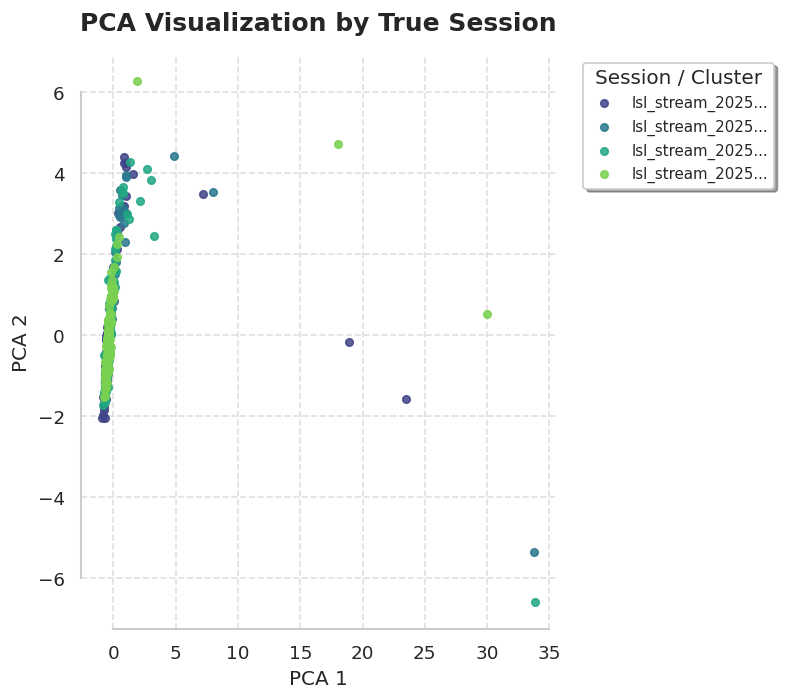

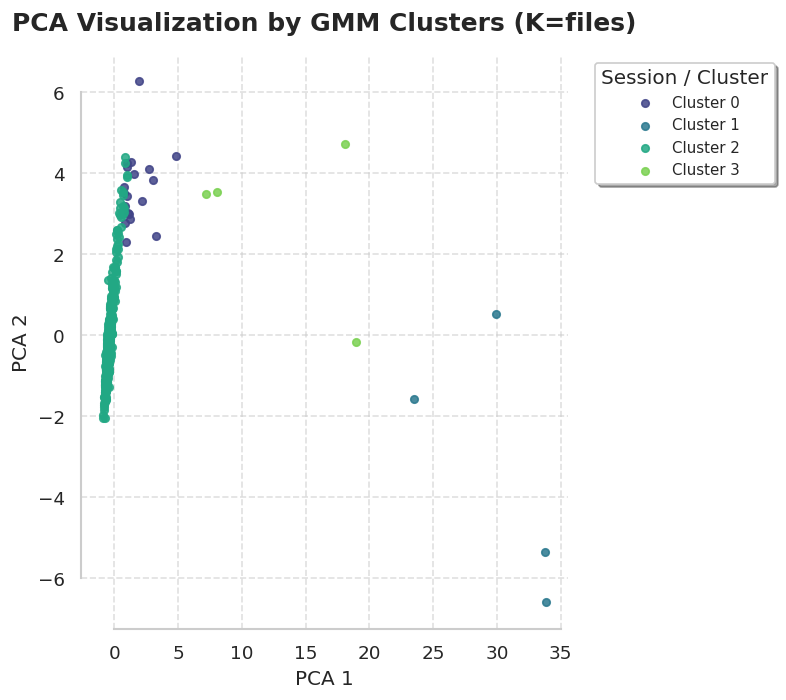

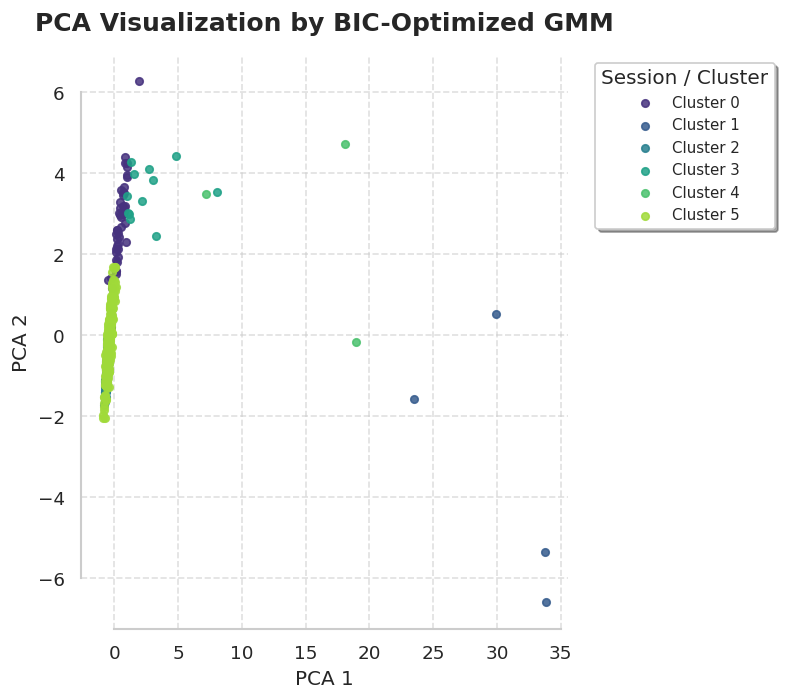


--- UMAP Visualizations ---


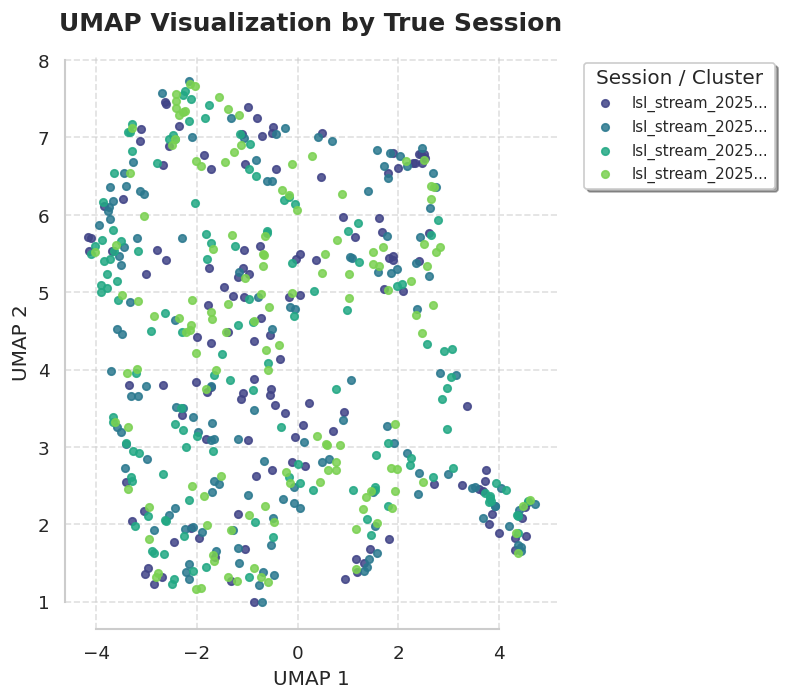

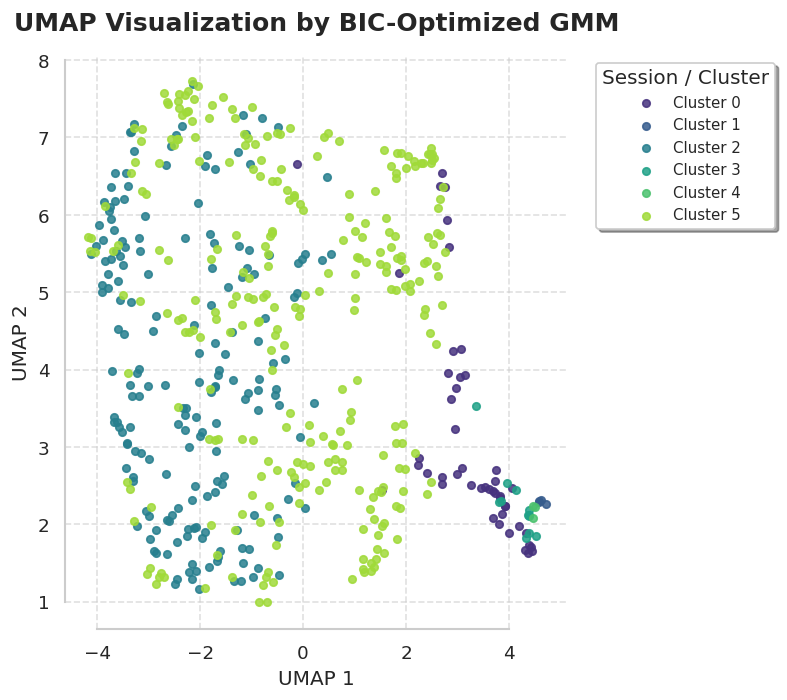

In [42]:
def plot_clusters(
    X2d: np.ndarray,
    labels,
    title: str,
    ax_labels: Tuple[str, str] = ("Dimension 1", "Dimension 2"),
):
    """
    Generates an improved scatter plot for visualizing clustered data.

    This function creates a scatter plot with:
    - A clear, informative title.
    - Labeled axes.
    - A visually distinct color palette for different clusters/sessions.
    - A well-placed legend with automatically shortened labels to prevent clutter.
    - A clean and modern aesthetic.
    """
    # Use pandas to handle unique labels robustly
    unique_labels = sorted(pd.Series(labels).unique())
    num_labels = len(unique_labels)

    # --- Create a mapping to shorter, readable legend labels ---
    label_map = {}
    # Check if labels are numeric (from clustering) or strings (from filenames)
    if np.issubdtype(np.array(labels).dtype, np.number):
        # For numeric cluster labels (e.g., 0, 1, 2...)
        for l in unique_labels:
            label_map[l] = f"Cluster {l}"
    else:  # For string labels (e.g., true session filenames)
        for l in unique_labels:
            # Truncate long filenames to keep the legend tidy
            label_text = str(l)
            if len(label_text) > 18:
                label_text = label_text[:15] + "..."
            label_map[l] = label_text

    # --- Plotting ---
    plt.figure(figsize=(8, 6))

    # Use a color palette that is good for categorical data (e.g., 'viridis', 'husl', 'tab10')
    palette = sns.color_palette("viridis", n_colors=num_labels)

    for i, label_val in enumerate(unique_labels):
        mask = labels == label_val
        plt.scatter(
            X2d[mask, 0],
            X2d[mask, 1],
            s=20,  # Slightly larger markers
            alpha=0.85,
            c=[palette[i]],  # Seaborn palettes return a list of tuples
            label=label_map[label_val],
        )

    plt.title(title, fontsize=15, weight="bold", pad=15)
    plt.xlabel(ax_labels[0], fontsize=12)
    plt.ylabel(ax_labels[1], fontsize=12)

    # --- Legend and Layout ---
    # Place legend outside the plot area for clarity
    lgnd = plt.legend(
        title="Session / Cluster",
        bbox_to_anchor=(1.04, 1),
        loc="upper left",
        frameon=True,
        shadow=True,
        fontsize=9,
    )

    sns.despine(trim=True)
    plt.grid(linestyle="--", alpha=0.6)

    # Adjust layout to prevent the legend from being cut off
    plt.tight_layout(rect=[0, 0, 0.85, 1])
    plt.show()


# --- Generate and Plot 2D Visualizations ---

# 1. PCA Visualizations
print("--- PCA Visualizations ---")
pca2 = PCA(n_components=2, random_state=0).fit_transform(Z)
plot_clusters(pca2, y_true, "PCA Visualization by True Session", ax_labels=("PCA 1", "PCA 2"))
plot_clusters(pca2, lab_gm, "PCA Visualization by GMM Clusters (K=files)", ax_labels=("PCA 1", "PCA 2"))
plot_clusters(pca2, lab_bic, "PCA Visualization by BIC-Optimized GMM", ax_labels=("PCA 1", "PCA 2"))


# 2. UMAP Visualizations
# Note: Tweaking UMAP parameters for potentially better visual separation.
print("\n--- UMAP Visualizations ---")
um2 = umap.UMAP(n_neighbors=25, min_dist=0.15, random_state=0).fit_transform(Zp)
plot_clusters(um2, y_true, "UMAP Visualization by True Session", ax_labels=("UMAP 1", "UMAP 2"))
plot_clusters(um2, lab_bic, "UMAP Visualization by BIC-Optimized GMM", ax_labels=("UMAP 1", "UMAP 2"))

In [41]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier

Xtr, Xte, ytr, yte = train_test_split(Z, y_enc, test_size=0.25, stratify=y_enc, random_state=0)

logreg = LogisticRegression(max_iter=4000, class_weight="balanced").fit(Xtr, ytr)
print("LogReg:\n", classification_report(yte, logreg.predict(Xte), digits=4))

xgb = XGBClassifier(n_estimators=400, max_depth=3, subsample=0.8, colsample_bytree=0.8,
                    reg_lambda=1.0, random_state=0).fit(Xtr, ytr)
print("XGB:\n", classification_report(yte, xgb.predict(Xte), digits=4))


LogReg:
               precision    recall  f1-score   support

           0     0.2326    0.3030    0.2632        33
           1     0.1250    0.0882    0.1034        34
           2     0.2619    0.3235    0.2895        34
           3     0.1600    0.1212    0.1379        33

    accuracy                         0.2090       134
   macro avg     0.1949    0.2090    0.1985       134
weighted avg     0.1948    0.2090    0.1985       134

XGB:
               precision    recall  f1-score   support

           0     0.9697    0.9697    0.9697        33
           1     0.9714    1.0000    0.9855        34
           2     1.0000    1.0000    1.0000        34
           3     1.0000    0.9697    0.9846        33

    accuracy                         0.9851       134
   macro avg     0.9853    0.9848    0.9850       134
weighted avg     0.9853    0.9851    0.9851       134



In [ ]:
out = data_std.copy()
out["cluster_kmeans"] = lab_km
out["cluster_gmmK"]   = lab_gm
out["cluster_bic"]    = lab_bic

out_path = "all_features_with_clusters.csv"
out.to_csv(out_path, index=False)
print("Saved:", out_path)

emb = pd.DataFrame({"pca1": pca2[:,0], "pca2": pca2[:,1],
                    "umap1": um2[:,0], "umap2": um2[:,1],
                    "true": y_true, "bic_cluster": lab_bic})
emb.to_csv("embeddings.csv", index=False)
print("Saved: embeddings.csv")


# EEGNet

In [7]:
!pip -q install tensorflow

In [8]:
import tensorflow as tf

# Check for available GPUs
gpu_devices = tf.config.list_physical_devices('GPU')
print(f"Num GPUs Available: {len(gpu_devices)}")

if gpu_devices:
    print("GPU is available and will be used automatically by TensorFlow.")
    # Print details of the detected GPU
    print("GPU Details:", gpu_devices[0])
else:
    print("No GPU was detected. The model will run on the CPU.")

Num GPUs Available: 1
GPU is available and will be used automatically by TensorFlow.
GPU Details: PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


In [16]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Activation, Dropout, Conv2D, DepthwiseConv2D, BatchNormalization, AveragePooling2D, Input, Flatten, SeparableConv2D
from tensorflow.keras.constraints import max_norm
from sklearn.model_selection import train_test_split

# --- 1. Collect All Epochs and Labels ---
all_epochs = []
all_labels = []

# EEGNet works well with shorter windows, e.g., 2-4 seconds
WIN_SECS = 4.0
OVL      = 0.5

for path, label in files_list:
    X, t, fs, chans = load_csv(path)
    print(f"Processing: {path}  (label={label})  inferred_fs={fs:.2f} Hz")

    X = preprocess(X, fs)
    # Epoch the data; Xep shape: (n_epochs, n_chans, n_samples_per_epoch)
    Xep, _ = epoch_array_safe(X, t, fs, win=WIN_SECS, ovl=OVL, min_win=2.0)

    if Xep.shape[0] == 0:
        print("  -> No valid epochs found; skipping file.")
        continue

    # Store the epochs and create a corresponding label for each one
    all_epochs.append(Xep)
    all_labels.extend([label] * Xep.shape[0])

# Concatenate data from all files into single NumPy arrays
X_data = np.concatenate(all_epochs, axis=0)
y_labels = np.array(all_labels)

print(f"\nTotal epochs collected: {X_data.shape[0]}")
print(f"Data shape (Epochs, Channels, Samples): {X_data.shape}")

# --- 2. Prepare Data for the Model ---

# A. Encode Labels: Convert string labels to one-hot encoded vectors
# (e.g., 'session_a' -> [1, 0, 0], 'session_b' -> [0, 1, 0])
le = LabelEncoder()
y_encoded = le.fit_transform(y_labels)
y_onehot = tf.keras.utils.to_categorical(y_encoded)
n_classes = y_onehot.shape[1]
class_names = le.classes_

# B. Reshape Data: The target repo uses 'channels_first' format.
# We will reshape to (Epochs, 1, Channels, Samples).
C = X_data.shape[1]  # Number of channels
T = X_data.shape[2]  # Number of time samples per epoch
X_reshaped = X_data.reshape(X_data.shape[0], 1, C, T)

print(f"Reshaped data for Keras (N, Kernels, Channels, Samples): {X_reshaped.shape}")

# C. Split Data: Create training and testing sets to evaluate the model
X_train, X_test, y_train, y_test = train_test_split(
    X_reshaped, y_onehot, test_size=0.25, random_state=42, stratify=y_onehot
)

print(f"\nTraining set size: {X_train.shape[0]} epochs")
print(f"Testing set size: {X_test.shape[0]} epochs")

Processing: lsl_stream_20250809_154545.csv  (label=lsl_stream_20250809_154545)  inferred_fs=250.00 Hz
Processing: lsl_stream_20250809_155123.csv  (label=lsl_stream_20250809_155123)  inferred_fs=250.00 Hz
Processing: lsl_stream_20250809_155739.csv  (label=lsl_stream_20250809_155739)  inferred_fs=250.00 Hz
Processing: lsl_stream_20250809_160350.csv  (label=lsl_stream_20250809_160350)  inferred_fs=250.00 Hz

Total epochs collected: 1077
Data shape (Epochs, Channels, Samples): (1077, 6, 1000)
Reshaped data for Keras (N, Kernels, Channels, Samples): (1077, 1, 6, 1000)

Training set size: 807 epochs
Testing set size: 270 epochs


In [17]:
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.constraints import max_norm
from tensorflow.keras import regularizers # Import the regularizers module

def EEGNet_RepoStyle(nb_classes, Chans=64, Samples=128, dropoutRate=0.25, F1=8, D=2, F2=16):
    """
    Keras implementation of EEGNet, adapted to match the parameters
    from the target PyTorch repository.
    - Uses channels_first data format.
    - Kernel sizes are (1, 51) and (1, 15).
    - Dropout rate is 0.25.
    """
    input1 = Input(shape=(1, Chans, Samples))

    # Block 1
    block1 = Conv2D(F1, (1, 51), padding='same', use_bias=False, data_format='channels_first')(input1)
    block1 = BatchNormalization(axis=1)(block1) # axis=1 for 'channels_first'
    block1 = DepthwiseConv2D((Chans, 1), use_bias=False, depth_multiplier=D,
                             depthwise_constraint=max_norm(1.), data_format='channels_first')(block1)
    block1 = BatchNormalization(axis=1)(block1)
    block1 = Activation('elu')(block1)
    block1 = AveragePooling2D((1, 4), data_format='channels_first')(block1)
    block1 = Dropout(dropoutRate)(block1)

    # Block 2
    block2 = SeparableConv2D(F2, (1, 15), use_bias=False, padding='same', data_format='channels_first')(block1)
    block2 = BatchNormalization(axis=1)(block2)
    block2 = Activation('elu')(block2)
    block2 = AveragePooling2D((1, 8), data_format='channels_first')(block2)
    block1 = Dropout(dropoutRate)(block1)

    # Classification Block
    flatten = Flatten(name='flatten')(block2)
    dense = Dense(nb_classes, name='dense', kernel_constraint=max_norm(0.25))(flatten)
    softmax = Activation('softmax', name='softmax')(dense)

    return Model(inputs=input1, outputs=softmax)

# --- Build and Compile the Repository-Style Model ---
model = EEGNet_RepoStyle(nb_classes=n_classes, Chans=C, Samples=T)
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 1, 6, 1000)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 8, 6, 1000)     │           408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 8, 6, 1000)     │            32 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ depthwise_conv2d                │ (None, 16, 1, 1000)    │            96 │
│ (DepthwiseConv2D)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 16, 1, 1000)    │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 16, 1, 1000)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling2d_1             │ (None, 16, 1, 250)     │             0 │
│ (AveragePooling2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 16, 1, 250)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ separable_conv2d                │ (None, 16, 1, 250)     │           496 │
│ (SeparableConv2D)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 16, 1, 250)     │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_3 (Activation)       │ (None, 16, 1, 250)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling2d_2             │ (None, 16, 1, 31)      │             0 │
│ (AveragePooling2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 496)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 4)              │         1,988 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ softmax (Activation)            │ (None, 4)              │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,148 (12.30 KB)

 Trainable params: 3,068 (11.98 KB)

 Non-trainable params: 80 (320.00 B)

In [18]:
# --- Callbacks can remain the same ---
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.2, patience=5, min_lr=1e-6, verbose=1)
model_checkpoint = tf.keras.callbacks.ModelCheckpoint('repo_style_net_best.h5', save_best_only=True, monitor='val_accuracy')

# --- Train the Model ---
BATCH_SIZE = 16
EPOCHS = 100

history = model.fit(
    X_train, y_train,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=(X_test, y_test),
    callbacks=[model_checkpoint, reduce_lr],
    verbose=1
)

Epoch 1/100
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - accuracy: 0.2989 - loss: 1.3837

51/51 ━━━━━━━━━━━━━━━━━━━━ 14s 108ms/step - accuracy: 0.2998 - loss: 1.3833 - val_accuracy: 0.2481 - val_loss: 1.4093 - learning_rate: 0.0010
Epoch 2/100
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.4215 - loss: 1.2666 - val_accuracy: 0.2481 - val_loss: 1.4520 - learning_rate: 0.0010
Epoch 3/100
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.4124 - loss: 1.2385 - val_accuracy: 0.2481 - val_loss: 1.5275 - learning_rate: 0.0010
Epoch 4/100
39/51 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.4671 - loss: 1.1372

51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.4745 - loss: 1.1365 - val_accuracy: 0.2519 - val_loss: 1.5920 - learning_rate: 0.0010
Epoch 5/100
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.4674 - loss: 1.1297 - val_accuracy: 0.2481 - val_loss: 1.7408 - learning_rate: 0.0010
Epoch 6/100
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.5021 - loss: 1.0831 - val_accuracy: 0.2519 - val_loss: 2.0533 - learning_rate: 0.0010
Epoch 7/100
50/51 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5605 - loss: 0.9933

51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.5586 - loss: 0.9961 - val_accuracy: 0.2556 - val_loss: 2.0468 - learning_rate: 0.0010
Epoch 8/100
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5681 - loss: 0.9945 - val_accuracy: 0.2556 - val_loss: 2.1132 - learning_rate: 0.0010
Epoch 9/100
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.4886 - loss: 1.0305 - val_accuracy: 0.2556 - val_loss: 2.3225 - learning_rate: 0.0010
Epoch 10/100
49/51 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5560 - loss: 1.0066

51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.5543 - loss: 1.0079 - val_accuracy: 0.2593 - val_loss: 2.4389 - learning_rate: 0.0010
Epoch 11/100
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.4898 - loss: 1.0332 - val_accuracy: 0.2556 - val_loss: 2.5128 - learning_rate: 0.0010
Epoch 12/100
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.4991 - loss: 1.0228 - val_accuracy: 0.2556 - val_loss: 2.6834 - learning_rate: 0.0010
Epoch 13/100
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.4916 - loss: 1.0449 - val_accuracy: 0.2519 - val_loss: 2.7469 - learning_rate: 0.0010
Epoch 14/100
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5749 - loss: 0.9227 - val_accuracy: 0.2481 - val_loss: 2.3480 - learning_rate: 0.0010
Epoch 15/100
44/51 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5974 - loss: 0.9396
Epoch 15: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.5929 - loss: 0.9452 - val_accuracy


--- Evaluating best model on test set ---
Test Accuracy: 0.2593


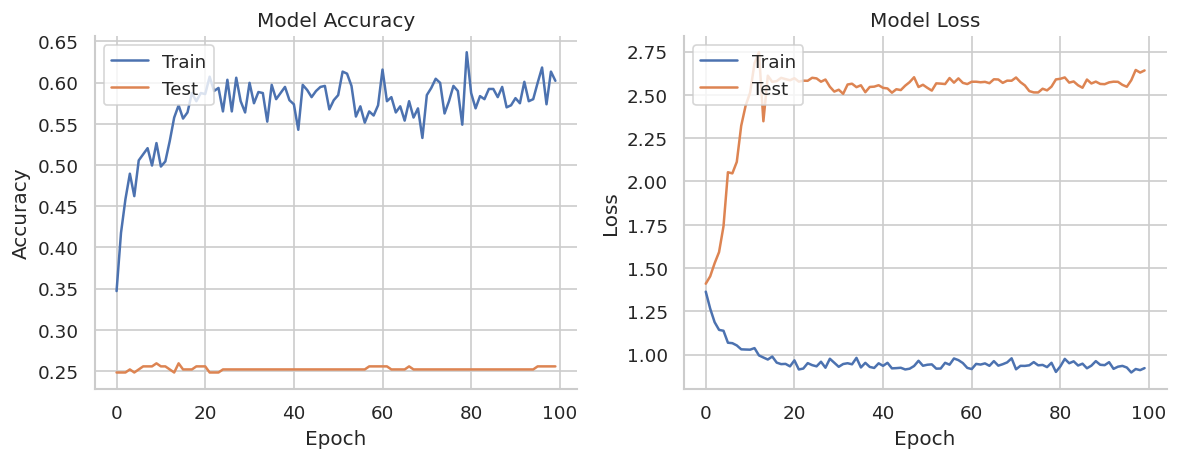

In [19]:
# --- Evaluate the Best Model ---
print("\n--- Evaluating best model on test set ---")
model.load_weights('repo_style_net_best.h5')
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=0)
print(f"Test Accuracy: {test_acc:.4f}")

# --- Plot Training History ---
def plot_history(history):
    plt.figure(figsize=(10, 4))

    # Plot training & validation accuracy values
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')
    sns.despine()

    # Plot training & validation loss values
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')
    sns.despine()

    plt.tight_layout()
    plt.show()

plot_history(history)